In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
from statsmodels.stats.multitest import multipletests
plt.rcParams.update({'font.size': 14})
from statsmodels.stats.proportion import proportion_confint

In [12]:
outpath = "output/frac_significant_quantile/"

In [3]:
sub = "dummy"
# dataname = "TSP1_10x_with_postprocessing_nopanc_cellann"
dataname = "TSP2_10x_rerun_with_postprocessing_3prime_cellann"
group = "ontology"
zscore_path = "../data/"
df = pd.read_parquet("{}{}_sym_SVD_normdonor_S_0.1_z_0.0_b_5.pq".format(zscore_path,dataname),columns=["geneR1A_uniq","tissue","compartment","cell","numReads","ontology","cell_gene"])
df["dummy"] = "dummy"
# subset to ontologies with > 20 cells
df["ontology_gene"] = df[group] + df["geneR1A_uniq"]
df["num_ont_gene"] = df["ontology_gene"].map(df.groupby("ontology_gene")["cell_gene"].nunique())
df = df[df["num_ont_gene"] > 10]
df["tiss_comp"] = df["tissue"] + df["compartment"]
df["gene_sub"] = df[sub] + df["geneR1A_uniq"]
df["numReads_sub"] = df.groupby("gene_sub")["numReads"].transform("sum")
df["numCells_sub"] = df["gene_sub"].map(df.groupby("gene_sub")["cell"].nunique())
df = df.drop_duplicates("gene_sub")

In [4]:
# pval_path = "/scratch/PI/horence/JuliaO/single_cell/SZS_pipeline2/scripts/output/variance_adjusted_permutations/"
pval_df = pd.read_csv("{}{}_pvals_{}-{}_100_S_0.1_z_0.0_b_5_sig.tsv".format(zscore_path,dataname,group,sub),sep="\t")

In [5]:
# sig = pval_df[(pval_df["perm_pval_adj_scZ"] < 0.05) & (pval_df["max_abs_median_scZ"] > ef)]
sig = pval_df[pval_df["sig"]]

In [6]:
sig["sub_col"] = sig["sub_col"].fillna("dummy")

/home/users/jolivier/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
sig["gene_sub"] = sig["sub_col"] + sig["geneR1A_uniq"]

/home/users/jolivier/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
df["sig"] = False
df.loc[df["gene_sub"].isin(sig["gene_sub"].unique()),"sig"] = True

In [9]:
num = 10
cats, bins = pd.qcut(df['numReads_sub'], num,retbins=True)

In [10]:
df['quantile'] = pd.qcut(df['numReads_sub'], num, labels=False)

[Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')]


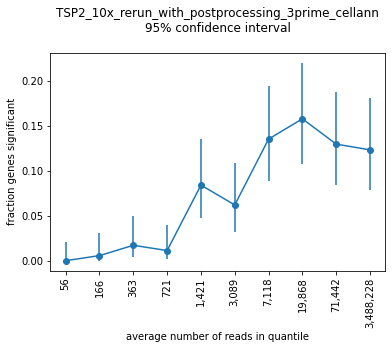

In [13]:
num_total = []
num_sig = []
for q, quant_df in df.groupby("quantile"):
  
  num_total.append(quant_df.shape[0])
  num_sig.append(quant_df["sig"].sum())
both = [proportion_confint(x,y,method="beta") for x, y in zip(num_sig, num_total)]
lower = [x[0] for x in both]
upper = [x[1] for x in both]
y_vals = [x/y for x, y in zip(num_sig, num_total)]
plt.errorbar(range(len(num_total)),y_vals,yerr=[[x - y for x, y in zip(y_vals, lower)],[y - x  for x, y in zip(y_vals, upper)]],marker="o")
ax = plt.gca()
print(ax.get_xticklabels())
plt.xlabel("average number of reads in quantile")
plt.ylabel("fraction genes significant")
plt.title("{}\n95% confidence interval\n".format(dataname))
# plt.xticks(range(20), ["{:,.0f}-{:,.0f}".format(x.left,x.right) for x in cats.unique().sort_values()], rotation='vertical')
plt.xticks(range(num), ["{0:,.0f}".format((x.left+x.right)/2) for x in cats.unique().sort_values()], rotation='vertical')

plt.savefig("{}{}_frac_sig.png".format(outpath,dataname),bbox_inches="tight")
plt.show()